VS code setup

In [1]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

# **StrawberyFields** 
or SF is a photonic quantum computing software developed by Xanadu. \
This tutorial is an introduction to SF, and also a brief look at continuous wave (CV) quantum computing. 


### But first,
We need to install stuff. We install StrawberryFields, IPyMPL and Matplotlib simply as: (Uncomment as needed)

In [2]:
# !pip install strawberryfields
# !pip install ipympl
# !pip install matplotlib

In [3]:
# Uncomment for creating interactive graphs
%matplotlib widget
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# Often assumed convention. Can be changed. 
sf.hbar = 1

and define some functions for data visualization used later.

In [4]:
def plot_phase_space(states, modes = [0], is3D = False):
    fig = plt.figure()
    cmap = "RdBu"
    
    scale = np.sqrt(2 * sf.hbar)
    q = np.linspace(-5.5, 5.5, 100)
    p = np.linspace(-5.5, 5.5, 100)
    
    q_mesh, p_mesh = np.meshgrid(q, p)

    index = 1
    if is3D:
        for state,mode in zip(states, modes):
            ax = fig.add_subplot(max(len(states)//3, 1), min(len(states), 3), index, projection="3d")
            Z = state.wigner(mode, q, p)

            upscale = np.max(Z.real)
            downscale = np.min(Z.real)
            nrm = mpl.colors.Normalize(downscale, upscale)
    
            ax.plot_surface(q_mesh, p_mesh, Z, cmap=cmap, lw=0.5, rstride=1, cstride=1, norm = nrm)

            index += 1
    else:
        for state,mode in zip(states, modes):
            ax = fig.add_subplot(max(len(states)//3, 1), min(len(states), 3), index)
            Z = state.wigner(mode, q, p)
            upscale = np.max(Z.real)
            downscale = np.min(Z.real)
            nrm = mpl.colors.Normalize(downscale, upscale)
    
            ax.pcolormesh(q_mesh/scale, p_mesh/scale, Z, cmap=cmap, lw=0.5, norm = nrm)
            index += 1

            ax.set_aspect('equal')
            ax.set_xlabel(r"Q (Units of $\sqrt{2\hbar}$)")
            ax.set_ylabel("P")
    fig.tight_layout()


# StrawberryFields Code
def calc_and_plot_marginals(state, mode):
    '''Calculates and plots the p, q-p, and q quadrature marginal
    distributions for a given circuit mode. These can be used to determine
    the Pauli X, Y, and Z outcomes for a GKP qubit.

    Args:
        state (object): a strawberryfields ``BaseBosonicState`` object
        mode (int): index for the circuit mode
    '''
    # Calculate the marginal distributions.
    # The rotation angle in phase space is specified by phi

    scale = np.sqrt(sf.hbar * np.pi)

    marginals = []
    phis = [np.pi / 2, -np.pi / 4, 0]
    quad = np.linspace(-5, 5, 400) * scale
    for phi in phis:
        marginals.append(state.marginal(mode, quad, phi=phi))

    # Plot the results
    paulis = ["X", "Y", "Z"]
    homodynes = ["p", "q-p", "q"]
    expectations = np.zeros(3)

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        if i == 1:
            # Rescale the outcomes for Pauli Y
            y_scale = np.sqrt(2 * sf.hbar) / scale
            axs[i].plot(quad * y_scale, marginals[i] / y_scale, 'k-')
            axs[i].set_xlim(quad[0] * y_scale, quad[-1] * y_scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad * y_scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] / y_scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad * y_scale)
        else:
            axs[i].plot(quad / scale, marginals[i] * scale, 'k-')
            axs[i].set_xlim(quad[0] / scale, quad[-1] / scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad / scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] * scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad / scale)

        # Color the qubit bins blue and red
        for j in range(-10, 10):
            axs[i].axvspan((2 * j - 0.5), (2 * j + 0.5), alpha=0.2, facecolor='b')
            axs[i].axvspan((2 * j + 0.5), (2 * j + 1.5), alpha=0.2, facecolor='r')

        axs[i].set_title("Homodyne data for Pauli " + paulis[i] +
                         "\n" + r'$\langle$'+paulis[i]+r'$\rangle$='+
                         str(np.around(expectations[i],2)))
        axs[i].set_xlabel(homodynes[i] + r' (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    axs[0].set_ylabel("Marginal distribution", fontsize=15)
    fig.tight_layout()
    plt.show()

### With the pleasantaries out of the way,
we can take a look at CV quantum computing.\
\
CV quantum computing is based on the Coherent state representation of quantum states. Contrary to the Fock state decomposition of quantum states which can be written as:
$$\ket{\psi} = \sum^N_{k=0} \braket{k|\psi}\ket{k}$$
(where $\ket{k}$ are orthogonal basis vectors of the hilbert space containing $\ket{\psi}$), coherent state decomposition uses coherent states to decompose (..duh) the quantum state [1]:
 $$\ket{\psi} = \int \phi(v)\ket{v}\bra{v} d^2v$$
Here, $\ket{v}$ is a coherent state and $v$ is a complex number. The basis formed by coherent states is over-complete and non-orthogonal. Hence, we can have several possible $\phi(v)$. Finally, $|v|^2$ is the mean photon number in the coherent state. 

### Coming back to StrawberryFields

* SF uses "qumodes" rather than the conventional qubit notation. Qumodes are bosonic modes which can (theoretically) have an infinite number of bodies occupying the same mode.
* In photonic quantum compuitng, we alter the distribution of systems occupying a given qumode, similar to the way we alter the amplitudes of different states in digital quantum computing.
* In SF, we'll be using the Wigner function to visualize qumodes in the phase-space. States with Gaussian Wigner fuctions are called Gaussian states. 

SF offers three backends:

| Backend   | Description |
| -         | - |
| Gaussian  | Meant for simulating gaussian states and gates (gates which map Gaussian states to other Gaussian states) |
| Fock      | Meant to handle non-gaussian states/gates|
| Bosonic   | Uses a combination of gaussian states to express non-gaussianity |
| Tf        | Meant for Quantum Machine Learning with TensorFlow |

We will be looking at the Gaussian and Bosonic backends for this tutorial.  

We start by creating some simple circuits in the phase space (complex space of $v$). First, we create a convenience funcion for running circuits.

In [5]:
def run_circuit(prog, backend="gaussian", eng=None):
    """
    Convenience function to run a circuit given a backend, engine and a program.
    """
    if eng == None:
        eng = sf.Engine(backend)
    state = eng.run(prog).state
    return state

We create a circuit with a single qumode and declare the qumode in the vacuum mode.

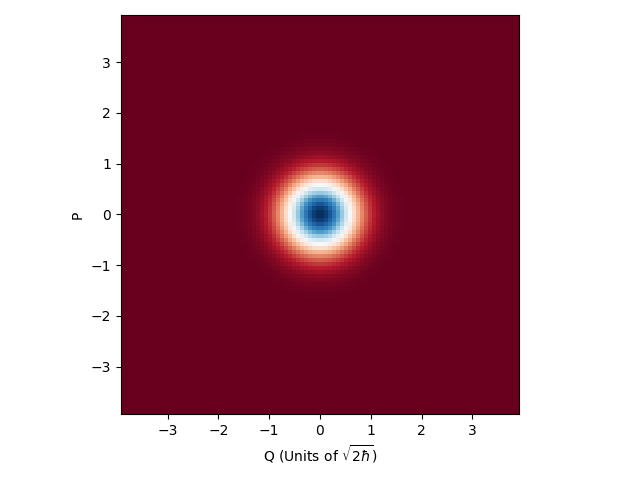

In [6]:
prog = sf.Program(1) # One qumode.
with prog.context as q:
    Vac | q[0]

state = run_circuit(prog, "gaussian")

plot_phase_space([state])

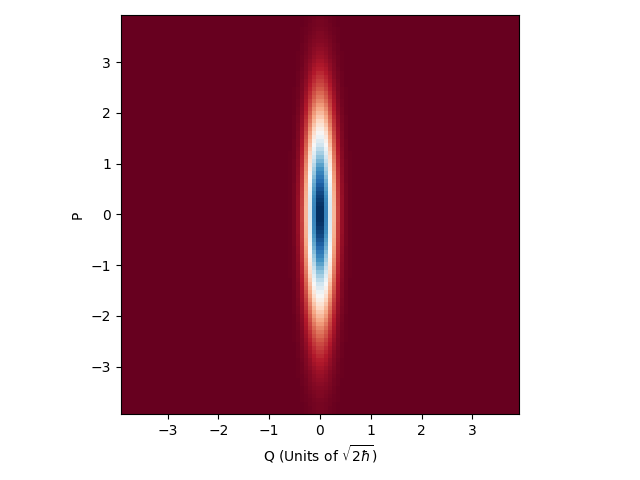

In [7]:
prog = sf.Program(1)
S = Sgate(1)
with prog.context as q:
    S | q[0]

state = run_circuit(prog, "gaussian")
plot_phase_space([state], is3D = False)

latex file \documentclass{article}
\pagestyle{empty}
\usepackage{qcircuit}
\begin{document}
\Qcircuit {
 & \gate{D}  & \gate{R}  & \qw \\
}
\end{document}
Dgate(2, 0) | (q[0])
Rgate(1.571) | (q[0])


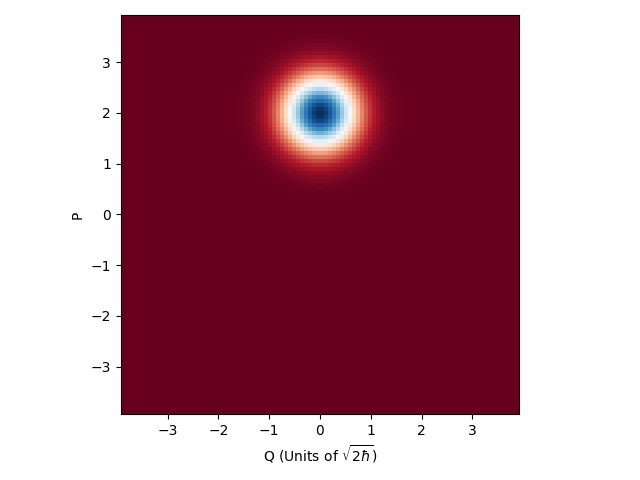

In [8]:
prog = sf.Program(1)
with prog.context as q:
    Dgate(2, 0) | q[0]
    Rgate(np.pi/2) | q[0]

print("latex file", prog.draw_circuit(write_to_file=True)[1])
prog.print()

state = run_circuit(prog, "gaussian")
plot_phase_space([state])

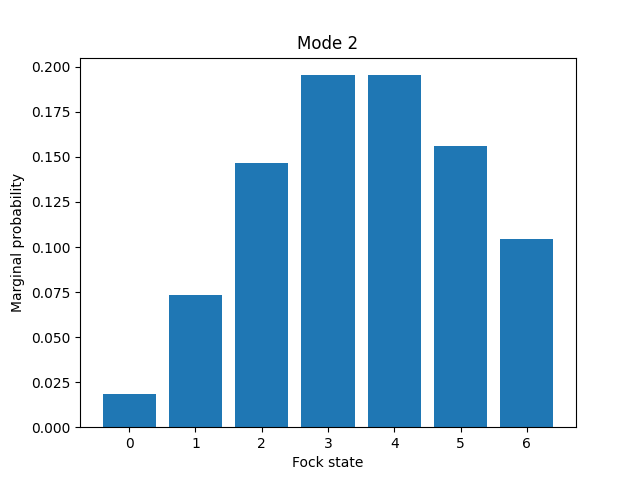

In [9]:
def displace_fock_space(d):
    prog = sf.Program(1)
    with prog.context as q:
        Dgate(d, 0) | q[0]
        
    eng = sf.Engine('fock', backend_options={"cutoff_dim": 15})

    state = eng.run(prog, shots=1).state
    rho = state.reduced_dm(0)
    probs = np.real_if_close(np.diagonal(rho))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(range(7), probs[:7])
    ax.set_xlabel('Fock state')
    ax.set_ylabel('Marginal probability')
    plt.title('Mode 2')
    plt.show()

displace_fock_space(np.sqrt(4))

## Time domain multiplexed circuits

Now that we are down with the basics, we can have a look at the computational model using Squeezed states. Computing happens using Time Domain multiplexing (or Time Division Multiplexing) where consecutive photons interact with each other before getting processed and eventually read out. 

We construct a basic TDM circuit to create the EPR state in the squeezed photons. We use the TDMProgram as opposed to the Program class of SF, which recycles qumodes to efficiently simulate multiple qumodes in succession. 

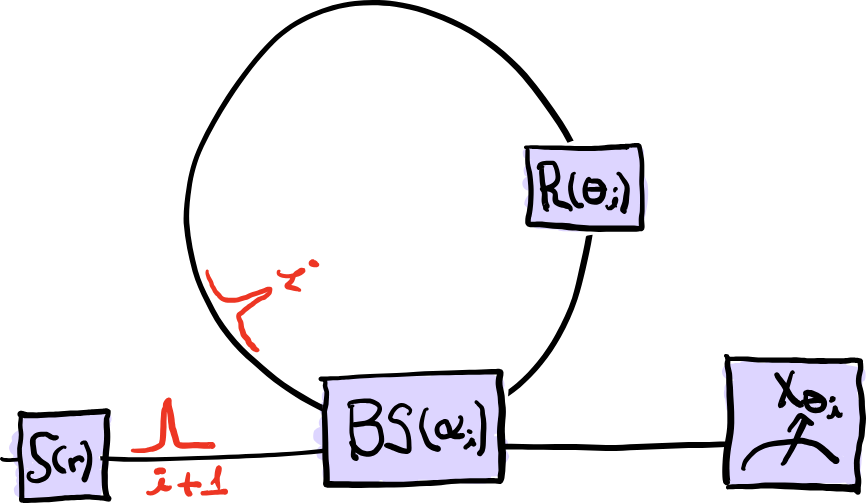

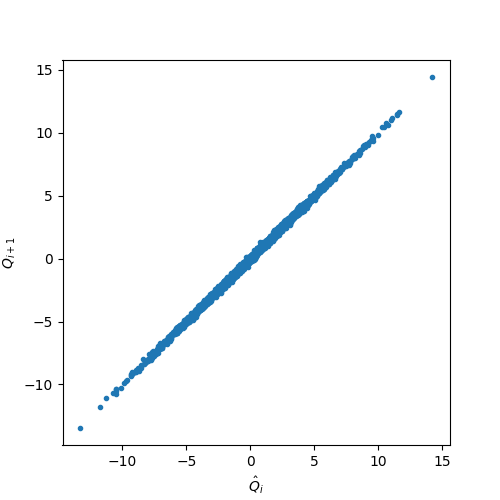

In [10]:
np.random.seed(42)

r = 2.0 # Squeezing parameter
shots = 2500

alpha = [np.pi / 4, 0]  # Beamsplitter parameter 
phi = [0, np.pi/2]      # Rotation angle in loop
theta = [0, 0]          # Homodyne Measurement 

prog = sf.TDMProgram(N=2) # N is the numbrer of concurrent modes in the circuit
with prog.context(alpha, phi, theta) as (p, q): # Here, p[0,1,2]=[alpha,phi,theta] and q = qumodes
    Sgate(r, 0) | q[1]
    BSgate(p[0]) | (q[0], q[1]) 
    Rgate(p[1]) | q[1]
    MeasureHomodyne(p[2]) | q[0]
eng = sf.Engine("gaussian")
result = eng.run(prog, shots=shots)

results = result.samples_dict[0].T

plt.figure(figsize=(5, 5))
plt.plot(results[0], results[1], ".")
plt.xlabel(r"$\hat{Q}_i$")
plt.ylabel(r"$\hat{Q}_{i+1}$")
plt.show()



We use **Homodyne measurement** for performing readouts in CV programs. Under homodyne measurement, you measure a single quadrature of the phase space (Q or P) by having the mode interfere with a local oscillator. Since in photonics you emit qumodes as pulses of coherent states, homodyne measuremnts generate a single measurement per mode. Hence, multiple shots of measurements need to be performed to create correlation plots.

In SF, ```MeasureHomodyne``` performs a projective measurement onto the state: $\text{cos}(\phi)\hat{Q}+\text{sin}(\phi)\hat{P}$. 

# GKP states
or, Squeezed states on steroids

 We use the **GKP** states [2] to encode digital data in the continuous phase space. GKP states are very resisant to errors and hence are considered to be an ideal state for encoding future quantum information (for bosonic systems)

In SF, GKP states are defined as: 
$$
    \ket{\psi} = \text{cos}(\theta/2)\ket{0}_{GKP} + e^{i\phi}\text{cos}(\theta/2)\ket{1}_{GKP}
$$
end hence, takes two parameters, $\theta$ and $\phi$

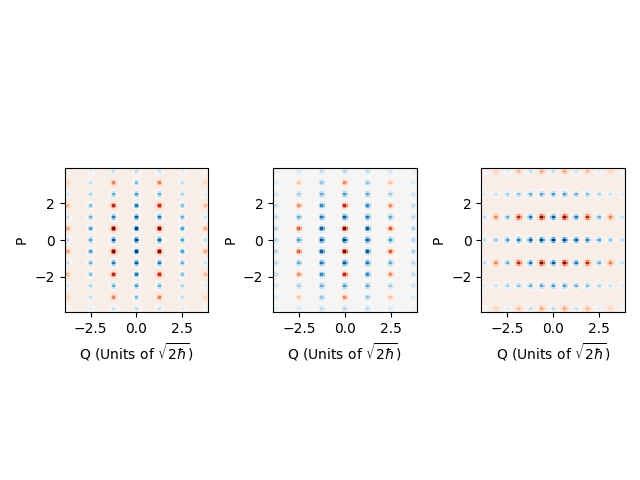

In [11]:
eng = sf.Engine("bosonic")

prog0 = sf.Program(1)
with prog0.context as q:
    sf.ops.GKP(state=[0, 0], epsilon = 0.04) | q
gkp0 = eng.run(prog0).state

prog1 = sf.Program(1)
with prog1.context as q:
    sf.ops.GKP(state = [np.pi, 0], epsilon = 0.04) | q
gkp1 = eng.run(prog1).state

progPlus = sf.Program(1)
with progPlus.context as q:
    sf.ops.GKP(state=[np.pi/2, 0], epsilon=0.04) | q
gkpPlus = eng.run(progPlus).state

plot_phase_space([gkp0,gkp1,gkpPlus], [0,0,0], is3D = False)

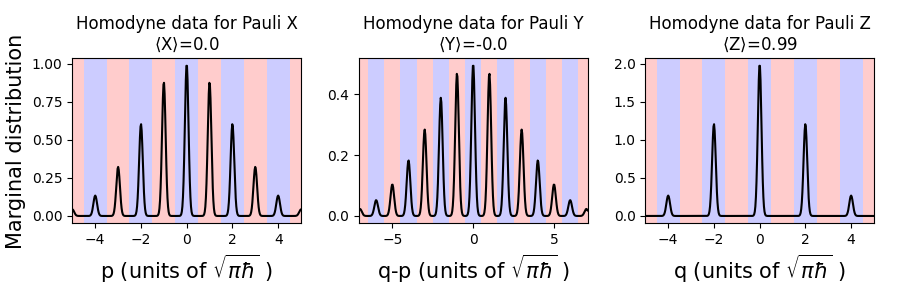

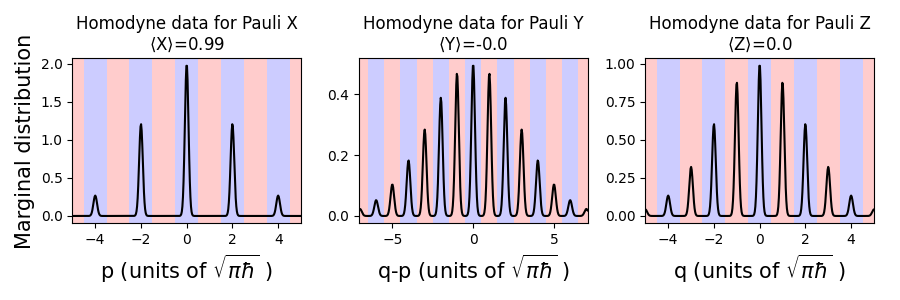

In [12]:
calc_and_plot_marginals(gkp0, 0)
calc_and_plot_marginals(gkpPlus, 0)

In GKP states, $\ket{1}$ is not necessarily the same as $X\ket{0}$. This is because for GKP states, the X gate is defined as a displacment along the Q quadrature. Hence, a repeated application of the X gate would shift the wigner function away from the origin, losing information. The logical information stored in the state is correct, but the readout becomes difficult. 

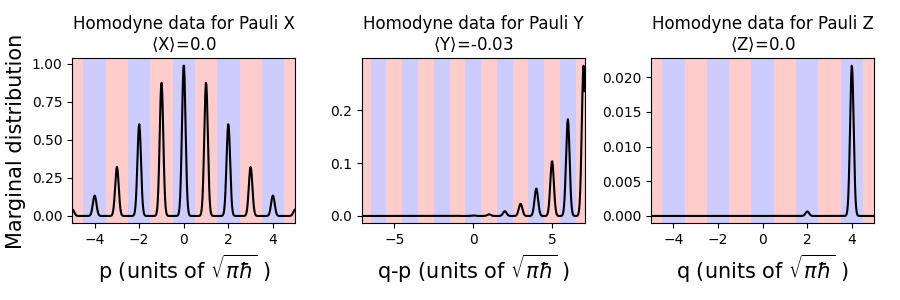

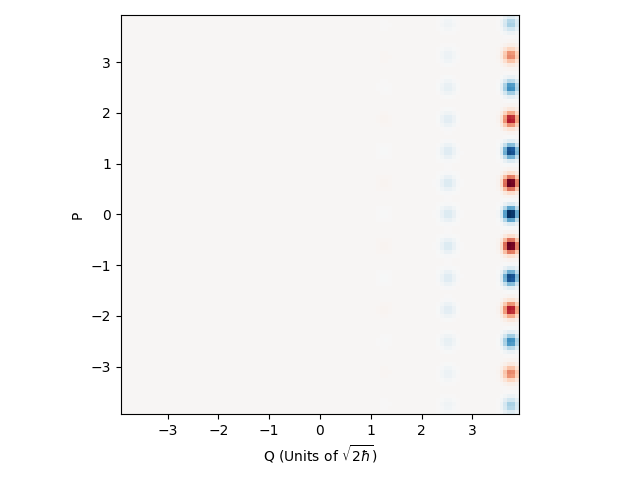

In [13]:
prog = sf.Program(1)
with prog.context as q:
    sf.ops.GKP(state=[0,0], epsilon=0.04) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q[0]
    
gkp = eng.run(prog).state

plot_phase_space([gkp], [0], is3D = False)
calc_and_plot_marginals(gkp, 0)